# APERO Demos

The aim of these demos is to walk you through some of the key steps in the
data reduction using APERO.

## Prerequisites for exercises

- Python 3.9  (e.g. via [conda](https://docs.conda.io/en/latest/miniconda.html))
    ```
    conda create --name=apero-demo python=3.9
    conda activate apero-demo
    pip install -r requirements.txt
    ```


- DS9 ([download](https://sites.google.com/cfa.harvard.edu/saoimageds9))


- dfits and fitsort
  - python implementation: [download](https://astrom-tom.github.io/dfitspy/build/html/installation.html)
  - C implmentation: [download](https://github.com/granttremblay/eso_fits_tools)


- Download the file bundle: [download](https://www.astro.umontreal.ca/~artigau/apero_demo/apero_nirps_demo.tar)


## Exercise 3: Calibrating a 2D image

- Step 1: Find the localization files (A and B)
- Step 2: Find the wavelength solution file
- Step 3: Find the preprocessed Proxima image
- Step 4: In python overplot the localization traces on the preprocessed image
- Step 5: In python add the wavelengths at 10 nm intervals to the step 4 plot
          (i.e. at …, 1200nm, 1210nm, 1220nm, 1230nm, …)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.interpolate import UnivariateSpline as IUSpline

In [6]:
# notebook only
%matplotlib inline

In [23]:
# all relevant files
image_file = 'NIRPS_2023-01-20T08_42_08_941_pp.fits'
loc_A_file = 'NIRPS_2022-11-25T11_13_50_435_pp_loco_A.fits'
loc_B_file = 'NIRPS_2022-11-25T11_15_30_766_pp_loco_B.fits'
wave_a_file = 'NIRPS_2022-11-25T12_00_56_233_pp_e2dsff_A_wavesol_ref_A.fits'

In [24]:
# read relevant data
loco_a = fits.getdata(loc_A_file)
loco_B = fits.getdata(loc_B_file)
wave_a = fits.getdata(wave_a_file)

In [25]:
# need to add a '4' as a constant. We trim the periphery of the pp image
#   calibrated images do not have the top/bottom/left/right pixels
image = fits.getdata(image_file)[4:-4, 4:-4][::-1, ::-1]

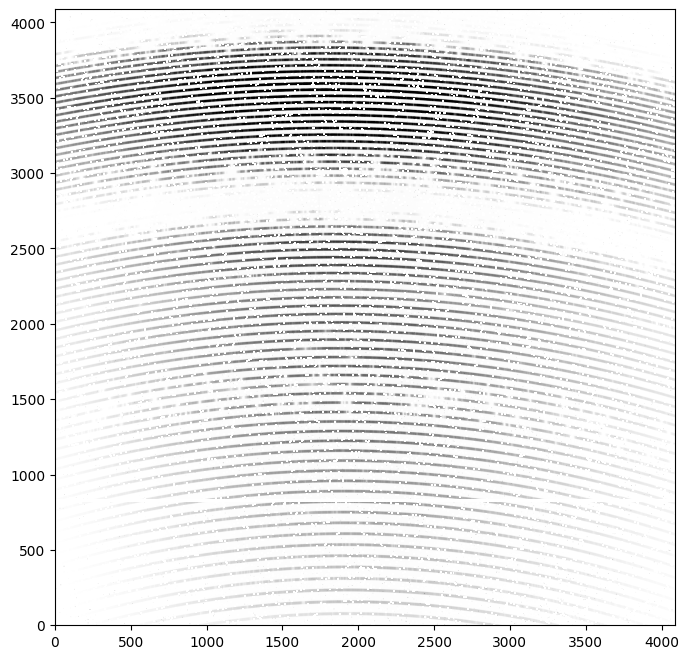

In [26]:
# find cuts for image display
vmin, vmax = np.nanpercentile(image, [5, 99])
# displaying image with cuts in greyscale
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, vmin=vmin, vmax=vmax, aspect='auto', origin='lower',
           cmap="gray_r")

In [27]:
# define a pixel grid
xpix = np.arange(image.shape[0])

# wavelengths that will be plotted
vals = np.arange(950, 1950, 10)

# pixel index along the dispersion direction
index = np.arange(loco_a.shape[1])

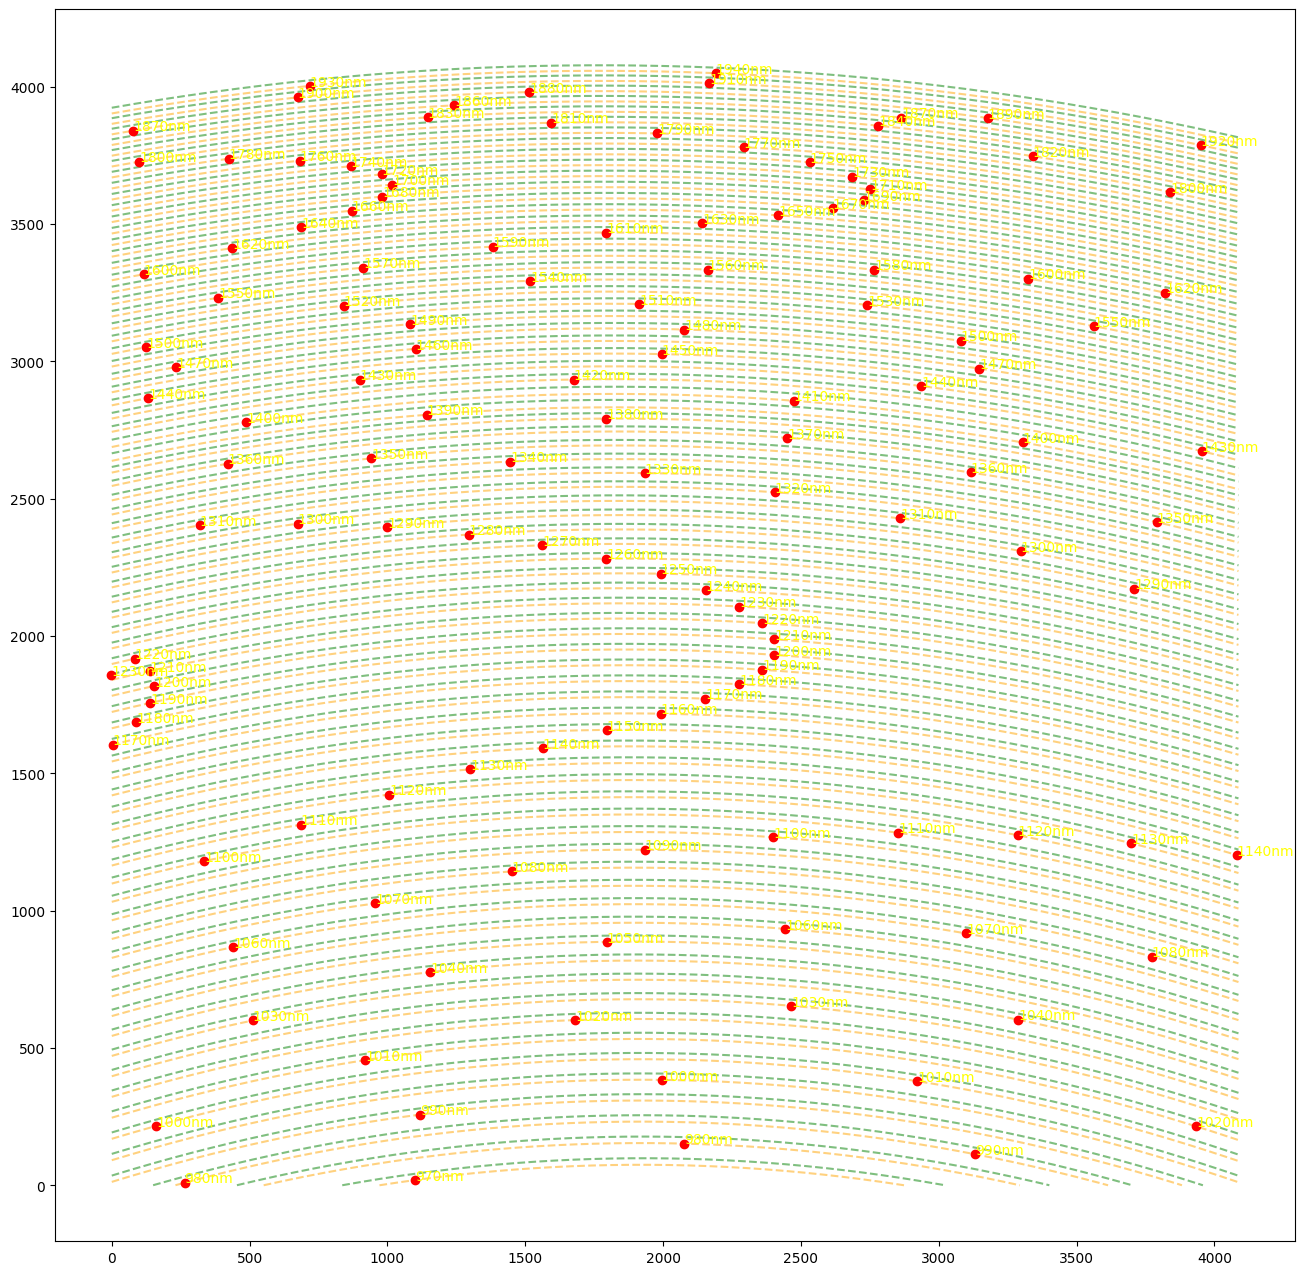

In [30]:
# set up a new plot
fig1, ax1 = plt.subplots(figsize=(16,16))

for order_num in range(loco_a.shape[0]):
    # spline the wavelength solution onto the values that will be plotted
    #   to get the pixel positions of the wavelength values
    xvals = IUSpline(wave_a[order_num], xpix, ext=1)(vals)
    # get a mask of good y-pixel locations for this order (fiber A)
    #   (should not be outside the image
    good = (loco_a[order_num] > 0) & (loco_a[order_num] < loco_a.shape[1])
    ax1.plot(index[good], loco_a[order_num][good], color='orange',
             linestyle='--', alpha=0.5)
    # only plot those pixel values not at zero
    good_vals = xvals != 0
    # don't plot if we have no values
    if np.sum(good_vals) != 0:
        # pixel positions that match good_vals
        xvals_plot = np.array(xvals[good_vals], dtype=int)
        # wavelength values that match good_vals
        vals_plot = vals[good_vals]
        # plot the localisation points as red dots
        plt.plot(xvals_plot, loco_a[order_num, xvals_plot], 'ro')
        # add text for each point (in yellow)
        for itxt in range(len(xvals_plot)):
            xplt = xvals_plot[itxt]
            yplt = loco_a[order_num, xvals_plot[itxt]]
            txt = '{:.0f}nm'.format(vals_plot[itxt])
            ax1.text(xplt, yplt, txt, color='yellow')
    # get a mask of good y-pixel location for this order (fiber B)
    good = (loco_B[order_num] > 0) & (loco_B[order_num] < loco_B.shape[1])
    ax1.plot(index[good], loco_B[order_num][good], color='green',
             linestyle='--', alpha=0.5)